In [1]:
import os
import torch
import cv2
import cPickle
import numpy as np

from faster_rcnn import network
from faster_rcnn.faster_rcnn import FasterRCNN, RPN
from faster_rcnn.utils.timer import Timer
from faster_rcnn.fast_rcnn.nms_wrapper import nms

from faster_rcnn.fast_rcnn.bbox_transform import bbox_transform_inv, clip_boxes
from faster_rcnn.datasets.factory import get_imdb
from faster_rcnn.fast_rcnn.config import cfg, cfg_from_file, get_output_dir

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300


# hyper-parameters
# ------------
#imdb_name = 'voc_2007_test'
#imdb_name = 'kittivoc_train'
#imdb_name = 'kittivoc_val'
imdb_name = 'kittipose_val'
#imdb_name = 'kitti_train'
cfg_file = 'experiments/cfgs/faster_rcnn_end2end.yml'
trained_model = 'models/saved_pose_model_p0/faster_rcnn_100000.h5'

# rand_seed = 1024

save_name = 'faster_rcnn_100000'
max_per_image = 300
thresh = 0.05
vis = True

# ------------

# load config
cfg_from_file(cfg_file)

In [2]:
# load data
imdb = get_imdb(imdb_name)
imdb.competition_mode(on=True)

# load net
net = FasterRCNN(classes=imdb.classes, debug=False)
network.load_net(trained_model, net)
print('load model successfully!')

net.cuda()
net.eval(); # set network to evaluation mode, which affects the behavior of batch norm, dropout, etc

<bound method kittipose.default_roidb of <faster_rcnn.datasets.kittipose.kittipose object at 0x7f33989d6090>>
Remove empty annotations:  Done. 
load model successfully!


In [11]:
def vis_detections(im, class_name, dets, poses, thresh=0.8):
    """Visual debugging of detections."""
    for i in range(np.minimum(10, dets.shape[0])):
        bbox = tuple(int(np.round(x)) for x in dets[i, :4])
        score = dets[i, -1]
        if score > thresh:
            cv2.rectangle(im, bbox[0:2], bbox[2:4], (0, 204, 0), 2)
            cv2.putText(im, '%s: %.3f Index %d' % (class_name, score, i), (bbox[0], bbox[1] + 15), cv2.FONT_HERSHEY_PLAIN,
                        1.0, (0, 0, 255), thickness=1)
            # apply inverse scaling to true values
            poses[i] = poses[i] / np.array(cfg.POSE_INV_VARS) + np.array(cfg.POSE_MEANS)
            print class_name, i, "pose:"
            print ["{0:0.2f}".format(p) for p in poses[i]]
    return im


def im_detect(net, image, disparity):
    """Detect object classes in an image given object proposals.
    Returns:
        scores (ndarray): R x K array of object class scores (K includes
            background as object category 0)
        boxes (ndarray): R x (4*K) array of predicted bounding boxes
    """
    # image.shape = H x W x 3
    # im_data, im_scales = net.get_image_blob(image)
    im_data, im_scales, disp_data = net.get_image_disparity_blob(image, disparity)
    # get_image_blob() tries to make H = 600 but keep W <= 1000
    # image gets resized, and the resize scale is returned
    # im_data: 1 x H x W x 3
    # im_scales: array with one number

    im_info = np.array(
        [[im_data.shape[1], im_data.shape[2], im_scales[0]]],
        dtype=np.float32)

    cls_prob, bbox_pred, pose_pred, rois = net(im_data, im_info, disp_data)
    # cls_prob.shape = (300, 4) # KITTI has four classes, '__background__', 'Car', 'Pedestrian', 'Cyclist'
    # bbox_pred.shape = (300, 16)
    # rois.shape = (300, 5)
    # pose_pred.shape = (300, 7)
    
    scores = cls_prob.data.cpu().numpy()
    boxes = rois.data.cpu().numpy()[:, 1:5] / im_info[0][2]
    poses = pose_pred.data.cpu().numpy() # convert pose prediction from torch to numpy
    cfg.TEST.BBOX_REG = True
    if cfg.TEST.BBOX_REG: # True in this case
        # Apply bounding-box regression deltas
        box_deltas = bbox_pred.data.cpu().numpy()
        pred_boxes = bbox_transform_inv(boxes, box_deltas)
        pred_boxes = clip_boxes(pred_boxes, image.shape)
        # pred_boxes.shape = (300, 16)
    else:
        # Simply repeat the boxes, once for each class
        pred_boxes = np.tile(boxes, (1, scores.shape[1]))

    return scores, pred_boxes, poses

# of images:  1480


Groundtruth labels:
Pedestrian 0.04 1 1.26 2.03 156.60 93.37 358.73 1.86 0.64 0.84 -5.58 1.72 7.14 0.61
Cyclist 0.00 1 0.72 41.60 168.23 215.57 318.25 1.83 0.58 1.95 -6.18 1.79 9.21 0.14
Car 0.00 0 2.04 1024.47 170.57 1168.44 228.94 1.48 1.51 4.35 13.56 1.43 20.11 2.63
Car 0.17 1 1.98 1130.43 172.17 1241.00 220.92 1.42 1.68 4.29 18.62 1.41 22.91 2.66

pedestrian 0 pose:
['1.75', '0.59', '1.65', '2.41', '1.53', '19.28', '-0.09']
car 0 pose:
['1.75', '0.68', '1.01', '0.49', '1.51', '10.87', '0.54']
car 1 pose:
['1.51', '1.66', '3.94', '-2.54', '1.74', '24.97', '-0.02']
cyclist 0 pose:
['1.51', '1.67', '4.00', '-4.86', '1.81', '22.51', '0.53']
im_detect: 916/1480 0.101s 0.000s


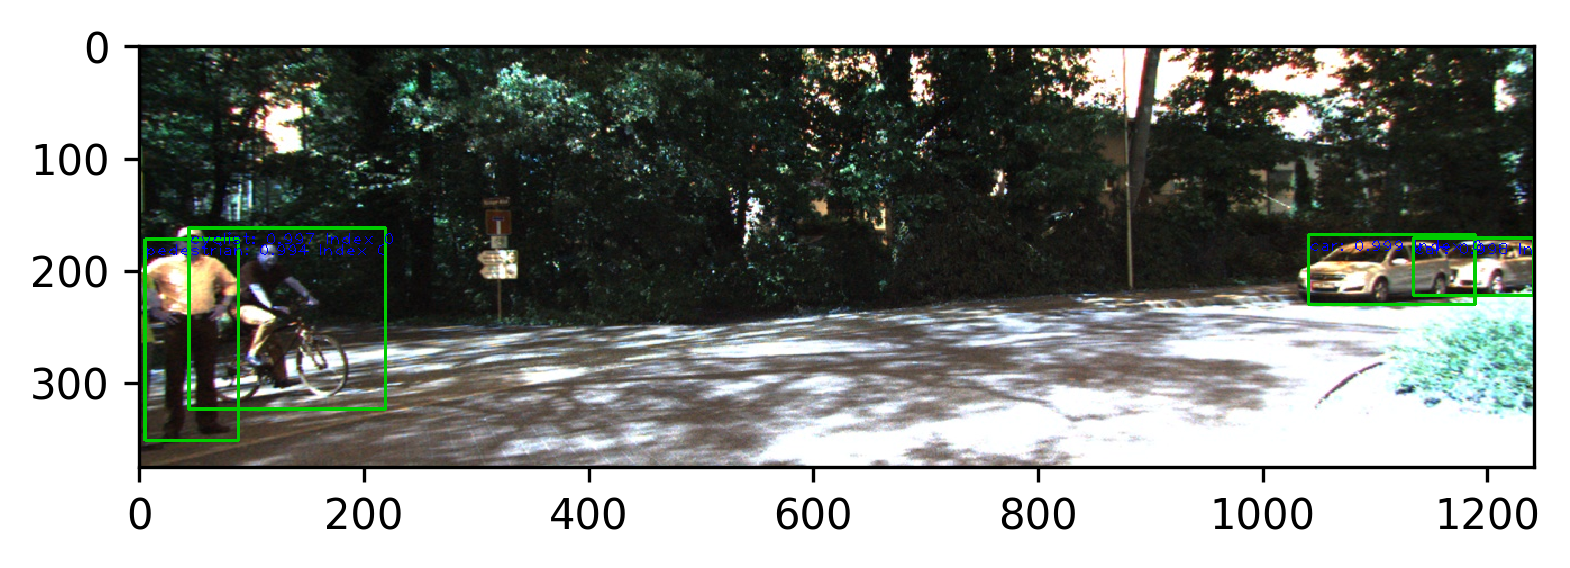

In [30]:
max_per_image=300
thresh=0.05
# idx_image = 6 # the idx of the image that we want to test
num_images = len(imdb.image_index)
idx_image = np.random.randint(0, num_images, 1)[0]


# all detections are collected into:
#    all_boxes[cls][image] = N x 5 array of detections in
#    (x1, y1, x2, y2, score)
all_boxes = [[[] for _ in xrange(num_images)]
             for _ in xrange(imdb.num_classes)]


# timers
_t = {'im_detect': Timer(), 'misc': Timer()}

print "# of images: ", num_images

# for i in range(num_images):
for i in range(idx_image,idx_image+1):
    im_path = imdb.image_path_at(i)
    folder = im_path[0:-10]
    img_name = im_path[-10:-3]
    img_name += 'png'
    disp_path = folder + 'disparity/' + img_name # path to disparity map
    
    im = cv2.imread(im_path)
    disp = cv2.imread(disp_path)
    
    # print out the groundtruth label
    print "\n"
    print "Groundtruth labels:"
    img_index = im_path[-10:-4]
    label_path = "/media/data/kitti_dataset/2d_object/data_object_image_2/training/label_2/" + img_index + ".txt"
    f = open(label_path, 'r')
    print(f.read())
    f.close()
    
    _t['im_detect'].tic()
    
    scores, boxes, poses = im_detect(net, im, disp_path)
    # scores.shape = (300, 4)
    # boxes.shape = (300, 16)
    # poses.shape = (300, 7)
    
    detect_time = _t['im_detect'].toc(average=False)

    
    if vis:
        # im2show = np.copy(im[:, :, (2, 1, 0)])
        im2show = np.copy(im)

    # skip j = 0, because it's the background class
    for j in xrange(1, imdb.num_classes):
        inds = np.where(scores[:, j] > thresh)[0]
        cls_scores = scores[inds, j]
        cls_boxes = boxes[inds, j * 4:(j + 1) * 4]
        cls_dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])) \
            .astype(np.float32, copy=False)
        keep = nms(cls_dets, cfg.TEST.NMS)
        cls_dets = cls_dets[keep, :]
        poses_keep = poses[keep, :]
        
        # print "# of", imdb._classes[j], ":", len(keep) # print class name
        
        
        if vis:
            im2show = vis_detections(im2show, imdb.classes[j], cls_dets, poses_keep)
        all_boxes[j][i] = cls_dets

    # Limit to max_per_image detections *over all classes*
    _t['misc'].tic()
    if max_per_image > 0:
        image_scores = np.hstack([all_boxes[j][i][:, -1]
                                  for j in xrange(1, imdb.num_classes)])
        if len(image_scores) > max_per_image:
            image_thresh = np.sort(image_scores)[-max_per_image]
            for j in xrange(1, imdb.num_classes):
                keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0]
                all_boxes[j][i] = all_boxes[j][i][keep, :]
    nms_time = _t['misc'].toc(average=False)

    print 'im_detect: {:d}/{:d} {:.3f}s {:.3f}s' \
        .format(i + 1, num_images, detect_time, nms_time)
        

    if vis:
        #cv2.imshow('test', im2show)
        #cv2.waitKey(0)
        plt.imshow(im2show)
        #pass